Aluno: Bruno Ricardo Pereira dos Santos Santos

Nº USP: 10288640


In [ ]:
from skimage import io
from PIL import Image 
from google.colab.patches import cv2_imshow # for image display
!pip install -U opencv-python
from random import randrange
import matplotlib.pyplot as plt
import numpy as np
import cv2
figsize = (10, 10)

 # Identificação do problema

A base usada contém imagens de raio-X do pulmão de diversos pacientes, classificados como tendo Pneumonia ou não. (https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

O objetivo desse trabalho é analisar as imagens, usar diferentes modelos para préprocessamento de imagens e diferentes classificadores para que possamos classificar por meio da imagem do paciente se ele tem pneumonia ou não.

Irei utilizar na etapa de préprocessamento o Bag of Visual Words e logo após usar diferentes classificadores. Além de usar Convolutional Neural Network (CNN).

# Pré-processamento

## Bag of visual Words

### Extraindo descritores SIFT de cada imagem


In [ ]:
from os import listdir
from os.path import isfile, join

dataset = '/content/drive/MyDrive/graduação/mineracao_dados_nao_estruturados/projeto2/data'


imagens = [f for f in listdir(dataset) if isfile(join(dataset, f))]

imagens

In [ ]:
from tqdm.notebook import tqdm

feature_extractor = cv2.SIFT_create()

L_imagem = []
L_classe = []
L_sift = []


for imagem in tqdm(imagens):
  if '.jpeg' in imagem:
    imagem_data = io.imread(dataset+'/'+imagem) 
    imagem_data = cv2.cvtColor(imagem_data, cv2.COLOR_BGR2RGB)
    _, sift_vectors = feature_extractor.detectAndCompute(imagem_data, None)
    L_imagem.append(imagem)
    L_classe.append(imagem.split("_")[0])
    L_sift.append(sift_vectors)

  0%|          | 0/5216 [00:00<?, ?it/s]

In [ ]:
import pandas as pd

df_data = pd.DataFrame()
df_data['imagem'] = L_imagem
df_data['sift'] = L_sift
df_data['classe'] = L_classe
df_data

,imagem,sift,classe
0,PNEUMONIA_ (1560).jpeg,"[[3.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 9.0, 5.0,...",PNEUMONIA
1,PNEUMONIA_ (1480).jpeg,"[[3.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 3.0, 3.0,...",PNEUMONIA
2,PNEUMONIA_ (1464).jpeg,"[[0.0, 1.0, 1.0, 1.0, 3.0, 2.0, 0.0, 1.0, 0.0,...",PNEUMONIA
3,PNEUMONIA_ (1648).jpeg,"[[9.0, 1.0, 0.0, 6.0, 12.0, 6.0, 0.0, 2.0, 142...",PNEUMONIA
4,PNEUMONIA_ (1586).jpeg,"[[0.0, 5.0, 10.0, 2.0, 0.0, 0.0, 0.0, 0.0, 6.0...",PNEUMONIA
...,...,...,...
5211,NORMAL_ (191).jpeg,"[[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 61.0...",NORMAL
5212,NORMAL_ (198).jpeg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0,...",NORMAL
5213,NORMAL_ (200).jpeg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",NORMAL
5214,NORMAL_ (221).jpeg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0,...",NORMAL


In [ ]:
L = []
for index,row in df_data.iterrows():
  L.append(len(row['sift']))

df_data['sift_total'] = L
df_data

,imagem,sift,classe,sift_total
0,PNEUMONIA_ (1560).jpeg,"[[3.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 9.0, 5.0,...",PNEUMONIA,218
1,PNEUMONIA_ (1480).jpeg,"[[3.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 3.0, 3.0,...",PNEUMONIA,282
2,PNEUMONIA_ (1464).jpeg,"[[0.0, 1.0, 1.0, 1.0, 3.0, 2.0, 0.0, 1.0, 0.0,...",PNEUMONIA,122
3,PNEUMONIA_ (1648).jpeg,"[[9.0, 1.0, 0.0, 6.0, 12.0, 6.0, 0.0, 2.0, 142...",PNEUMONIA,87
4,PNEUMONIA_ (1586).jpeg,"[[0.0, 5.0, 10.0, 2.0, 0.0, 0.0, 0.0, 0.0, 6.0...",PNEUMONIA,368
...,...,...,...,...
5211,NORMAL_ (191).jpeg,"[[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 61.0...",NORMAL,509
5212,NORMAL_ (198).jpeg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0,...",NORMAL,761
5213,NORMAL_ (200).jpeg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",NORMAL,742
5214,NORMAL_ (221).jpeg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0,...",NORMAL,565


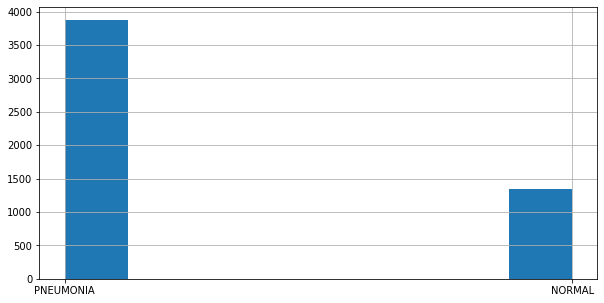

In [ ]:
df_data.classe.hist(figsize=(10,5),bins=8)

In [ ]:
df_data = df_data.sample(frac=1) # shuffle
df_data

,imagem,sift,classe,sift_total
1227,PNEUMONIA_ (872).jpeg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0...",PNEUMONIA,362
1008,PNEUMONIA_ (592).jpeg,"[[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 153....",PNEUMONIA,449
3364,PNEUMONIA_ (2505).jpeg,"[[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0,...",PNEUMONIA,242
3127,NORMAL_ (1334).jpeg,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 110....",NORMAL,195
5148,NORMAL_ (163).jpeg,"[[101.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 15...",NORMAL,588
...,...,...,...,...
4031,NORMAL_ (267).jpeg,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0,...",NORMAL,430
2318,PNEUMONIA_ (3472).jpeg,"[[40.0, 6.0, 3.0, 4.0, 8.0, 2.0, 0.0, 1.0, 164...",PNEUMONIA,207
4990,NORMAL_ (1184).jpeg,"[[0.0, 0.0, 3.0, 14.0, 17.0, 1.0, 0.0, 0.0, 3....",NORMAL,395
3486,PNEUMONIA_ (338).jpeg,"[[37.0, 11.0, 11.0, 11.0, 11.0, 0.0, 0.0, 0.0,...",PNEUMONIA,662


### Agrupando descritores SIFT para gerar as Visual Words

#### Gerando dataset de descritores SIFT

In [ ]:
X_sift = []
for index,row in df_data.iterrows():
  for sift_vector in row['sift']:
    X_sift.append(sift_vector)

In [ ]:
X_sift = np.array(X_sift)
X_sift.shape

(1636302, 128)

In [ ]:
X_sift

array([[  0.,   0.,   0., ...,   4.,   0.,   1.],
       [  6.,  12.,   4., ...,   1.,   0.,   0.],
       [  0.,   0.,   2., ...,  11.,   2.,   0.],
       ...,
       [136.,  49.,   1., ...,   0.,   0.,  12.],
       [  0.,   0.,   0., ...,   1.,   7.,  25.],
       [ 40.,   0.,   0., ...,   0.,  91.,  31.]], dtype=float32)

#### Agrupamento de descritores

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import numpy as np
from sklearn.model_selection import train_test_split

num_visual_words = 100
kmeans = MiniBatchKMeans(n_clusters=num_visual_words, n_init=1, max_iter=10, init='random', verbose=1)

kmeans.fit(X_sift)

Init 1/1 with method random
Inertia for init 1/1: 341483904.0
Minibatch step 1/15979: mean batch inertia: 110661.8125
Minibatch step 2/15979: mean batch inertia: 79686.3203125, ewa inertia: 79686.3203125
Minibatch step 3/15979: mean batch inertia: 75985.96875, ewa inertia: 79681.68894532656
Minibatch step 4/15979: mean batch inertia: 75532.0078125, ewa inertia: 79676.49519639373
Minibatch step 5/15979: mean batch inertia: 74012.5703125, ewa inertia: 79669.40621705298
Minibatch step 6/15979: mean batch inertia: 73589.984375, ewa inertia: 79661.79720091568
Minibatch step 7/15979: mean batch inertia: 73863.5625, ewa inertia: 79654.54011914814
Minibatch step 8/15979: mean batch inertia: 72968.765625, ewa inertia: 79646.17219085856
Minibatch step 9/15979: mean batch inertia: 72223.390625, ewa inertia: 79636.8818230924
Minibatch step 10/15979: mean batch inertia: 72019.5, ewa inertia: 79627.34789326786
Minibatch step 11/15979: mean batch inertia: 73605.1015625, ewa inertia: 79619.81043811106

MiniBatchKMeans(init='random', max_iter=10, n_clusters=100, n_init=1, verbose=1)

In [ ]:
df_visual_words = pd.DataFrame(X_sift)
df_visual_words

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,10.0,0.0,0.0,2.0,4.0,1.0,1.0,192.0,84.0,1.0,3.0,4.0,1.0,0.0,1.0,26.0,14.0,1.0,20.0,63.0,1.0,0.0,0.0,4.0,12.0,3.0,0.0,0.0,0.0,0.0,0.0,...,64.0,1.0,0.0,5.0,65.0,20.0,0.0,2.0,28.0,4.0,0.0,0.0,0.0,0.0,2.0,18.0,162.0,1.0,0.0,0.0,0.0,0.0,0.0,25.0,192.0,1.0,0.0,1.0,3.0,0.0,0.0,19.0,44.0,1.0,0.0,6.0,50.0,4.0,0.0,1.0
1,6.0,12.0,4.0,0.0,1.0,2.0,2.0,4.0,96.0,7.0,1.0,0.0,1.0,2.0,7.0,13.0,217.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,50.0,0.0,0.0,0.0,28.0,0.0,0.0,1.0,16.0,18.0,1.0,0.0,0.0,0.0,0.0,5.0,...,62.0,0.0,0.0,1.0,37.0,0.0,0.0,0.0,28.0,6.0,2.0,0.0,0.0,0.0,1.0,7.0,97.0,9.0,5.0,0.0,0.0,0.0,1.0,3.0,217.0,16.0,2.0,0.0,0.0,0.0,0.0,0.0,46.0,4.0,11.0,3.0,28.0,1.0,0.0,0.0
2,0.0,0.0,2.0,13.0,3.0,2.0,4.0,0.0,0.0,0.0,0.0,12.0,21.0,7.0,23.0,7.0,0.0,0.0,0.0,2.0,14.0,37.0,34.0,2.0,0.0,0.0,0.0,0.0,7.0,28.0,12.0,0.0,8.0,0.0,1.0,5.0,1.0,2.0,9.0,11.0,...,0.0,0.0,0.0,0.0,103.0,30.0,1.0,0.0,9.0,5.0,1.0,0.0,9.0,152.0,29.0,4.0,155.0,21.0,0.0,0.0,17.0,11.0,31.0,55.0,67.0,4.0,0.0,1.0,155.0,24.0,0.0,9.0,0.0,1.0,0.0,3.0,85.0,11.0,2.0,0.0
3,42.0,15.0,1.0,0.0,0.0,1.0,0.0,7.0,159.0,1.0,0.0,6.0,28.0,0.0,0.0,40.0,53.0,4.0,28.0,88.0,159.0,1.0,0.0,5.0,21.0,127.0,48.0,17.0,23.0,2.0,1.0,0.0,101.0,14.0,0.0,0.0,0.0,0.0,0.0,5.0,...,1.0,4.0,10.0,11.0,9.0,0.0,1.0,3.0,7.0,35.0,10.0,0.0,0.0,0.0,0.0,0.0,19.0,34.0,28.0,1.0,0.0,0.0,0.0,6.0,13.0,6.0,21.0,6.0,0.0,0.0,1.0,17.0,2.0,2.0,2.0,0.0,0.0,0.0,4.0,14.0
4,20.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,13.0,1.0,0.0,0.0,0.0,0.0,11.0,28.0,2.0,0.0,0.0,0.0,0.0,0.0,55.0,27.0,0.0,0.0,0.0,0.0,0.0,3.0,56.0,13.0,36.0,7.0,0.0,0.0,0.0,0.0,3.0,7.0,...,44.0,103.0,95.0,15.0,9.0,4.0,9.0,6.0,20.0,0.0,0.0,0.0,0.0,2.0,9.0,4.0,146.0,14.0,0.0,0.0,23.0,6.0,1.0,5.0,60.0,3.0,0.0,3.0,146.0,83.0,31.0,8.0,41.0,5.0,1.0,2.0,12.0,12.0,52.0,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1636297,50.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0,50.0,0.0,0.0,0.0,0.0,0.0,6.0,145.0,24.0,0.0,0.0,0.0,0.0,0.0,31.0,31.0,1.0,0.0,2.0,18.0,9.0,5.0,18.0,61.0,9.0,0.0,0.0,0.0,0.0,0.0,1.0,...,62.0,34.0,13.0,0.0,1.0,2.0,4.0,70.0,3.0,1.0,0.0,0.0,0.0,1.0,4.0,8.0,131.0,37.0,0.0,0.0,0.0,1.0,2.0,4.0,145.0,71.0,1.0,0.0,0.0,0.0,0.0,30.0,46.0,68.0,3.0,0.0,0.0,0.0,0.0,20.0
1636298,150.0,126.0,1.0,0.0,0.0,0.0,0.0,2.0,83.0,128.0,9.0,6.0,3.0,0.0,0.0,6.0,21.0,19.0,9.0,32.0,26.0,7.0,25.0,18.0,0.0,5.0,12.0,31.0,13.0,11.0,50.0,5.0,150.0,101.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,8.0,3.0,3.0,2.0,1.0,0.0,0.0,150.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1636299,136.0,49.0,1.0,0.0,0.0,0.0,0.0,10.0,119.0,97.0,42.0,0.0,0.0,0.0,0.0,18.0,33.0,66.0,43.0,1.0,4.0,1.0,0.0,15.0,10.0,8.0,3.0,2.0,21.0,28.0,20.0,8.0,95.0,119.0,2.0,0.0,0.0,0.0,1.0,2.0,...,34.0,75.0,10.0,14.0,9.0,1.0,1.0,6.0,52.0,10.0,0.0,0.0,0.0,1.0,2.0,3.0,136.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,109.0,56.0,0.0,0.0,0.0,0.0,0.0,1.0,56.0,24.0,2.0,2.0,1.0,0.0,0.0,12.0
1636300,0.0,0.0,0.0,0.0,1.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,24.0,75.0,0.0,0.0,0.0,0.0,0.0,0.0,92.0,130.0,0.0,0.0,0.0,0.0,0.0,11.0,130.0,38.0,8.0,0.0,0.0,0.0,0.0,2.0,23.0,44.0,...,10.0,1.0,0.0,0.0,0.0,2.0,47.0,63.0,1.0,0.0,0.0,0.0,0.0,130.0,66.0,1.0,64.0,38.0,0.0,0.0,0.0,93.0,25.0,7.0,130.0,129.0,0.0,0.0,0.0,1.0,2.0,6.0,64.0,23.0,0.0,0.0,0.0,1.0,7.0,25.0


In [ ]:
df_visual_words['visual_word'] = kmeans.labels_
df_visual_words

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,visual_word
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,10.0,0.0,0.0,2.0,4.0,1.0,1.0,192.0,84.0,1.0,3.0,4.0,1.0,0.0,1.0,26.0,14.0,1.0,20.0,63.0,1.0,0.0,0.0,4.0,12.0,3.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,65.0,20.0,0.0,2.0,28.0,4.0,0.0,0.0,0.0,0.0,2.0,18.0,162.0,1.0,0.0,0.0,0.0,0.0,0.0,25.0,192.0,1.0,0.0,1.0,3.0,0.0,0.0,19.0,44.0,1.0,0.0,6.0,50.0,4.0,0.0,1.0,42
1,6.0,12.0,4.0,0.0,1.0,2.0,2.0,4.0,96.0,7.0,1.0,0.0,1.0,2.0,7.0,13.0,217.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,50.0,0.0,0.0,0.0,28.0,0.0,0.0,1.0,16.0,18.0,1.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,1.0,37.0,0.0,0.0,0.0,28.0,6.0,2.0,0.0,0.0,0.0,1.0,7.0,97.0,9.0,5.0,0.0,0.0,0.0,1.0,3.0,217.0,16.0,2.0,0.0,0.0,0.0,0.0,0.0,46.0,4.0,11.0,3.0,28.0,1.0,0.0,0.0,1
2,0.0,0.0,2.0,13.0,3.0,2.0,4.0,0.0,0.0,0.0,0.0,12.0,21.0,7.0,23.0,7.0,0.0,0.0,0.0,2.0,14.0,37.0,34.0,2.0,0.0,0.0,0.0,0.0,7.0,28.0,12.0,0.0,8.0,0.0,1.0,5.0,1.0,2.0,9.0,11.0,...,0.0,0.0,0.0,103.0,30.0,1.0,0.0,9.0,5.0,1.0,0.0,9.0,152.0,29.0,4.0,155.0,21.0,0.0,0.0,17.0,11.0,31.0,55.0,67.0,4.0,0.0,1.0,155.0,24.0,0.0,9.0,0.0,1.0,0.0,3.0,85.0,11.0,2.0,0.0,13
3,42.0,15.0,1.0,0.0,0.0,1.0,0.0,7.0,159.0,1.0,0.0,6.0,28.0,0.0,0.0,40.0,53.0,4.0,28.0,88.0,159.0,1.0,0.0,5.0,21.0,127.0,48.0,17.0,23.0,2.0,1.0,0.0,101.0,14.0,0.0,0.0,0.0,0.0,0.0,5.0,...,4.0,10.0,11.0,9.0,0.0,1.0,3.0,7.0,35.0,10.0,0.0,0.0,0.0,0.0,0.0,19.0,34.0,28.0,1.0,0.0,0.0,0.0,6.0,13.0,6.0,21.0,6.0,0.0,0.0,1.0,17.0,2.0,2.0,2.0,0.0,0.0,0.0,4.0,14.0,63
4,20.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,13.0,1.0,0.0,0.0,0.0,0.0,11.0,28.0,2.0,0.0,0.0,0.0,0.0,0.0,55.0,27.0,0.0,0.0,0.0,0.0,0.0,3.0,56.0,13.0,36.0,7.0,0.0,0.0,0.0,0.0,3.0,7.0,...,103.0,95.0,15.0,9.0,4.0,9.0,6.0,20.0,0.0,0.0,0.0,0.0,2.0,9.0,4.0,146.0,14.0,0.0,0.0,23.0,6.0,1.0,5.0,60.0,3.0,0.0,3.0,146.0,83.0,31.0,8.0,41.0,5.0,1.0,2.0,12.0,12.0,52.0,81.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1636297,50.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0,50.0,0.0,0.0,0.0,0.0,0.0,6.0,145.0,24.0,0.0,0.0,0.0,0.0,0.0,31.0,31.0,1.0,0.0,2.0,18.0,9.0,5.0,18.0,61.0,9.0,0.0,0.0,0.0,0.0,0.0,1.0,...,34.0,13.0,0.0,1.0,2.0,4.0,70.0,3.0,1.0,0.0,0.0,0.0,1.0,4.0,8.0,131.0,37.0,0.0,0.0,0.0,1.0,2.0,4.0,145.0,71.0,1.0,0.0,0.0,0.0,0.0,30.0,46.0,68.0,3.0,0.0,0.0,0.0,0.0,20.0,76
1636298,150.0,126.0,1.0,0.0,0.0,0.0,0.0,2.0,83.0,128.0,9.0,6.0,3.0,0.0,0.0,6.0,21.0,19.0,9.0,32.0,26.0,7.0,25.0,18.0,0.0,5.0,12.0,31.0,13.0,11.0,50.0,5.0,150.0,101.0,0.0,0.0,0.0,0.0,0.0,1.0,...,8.0,3.0,3.0,2.0,1.0,0.0,0.0,150.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48
1636299,136.0,49.0,1.0,0.0,0.0,0.0,0.0,10.0,119.0,97.0,42.0,0.0,0.0,0.0,0.0,18.0,33.0,66.0,43.0,1.0,4.0,1.0,0.0,15.0,10.0,8.0,3.0,2.0,21.0,28.0,20.0,8.0,95.0,119.0,2.0,0.0,0.0,0.0,1.0,2.0,...,75.0,10.0,14.0,9.0,1.0,1.0,6.0,52.0,10.0,0.0,0.0,0.0,1.0,2.0,3.0,136.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,109.0,56.0,0.0,0.0,0.0,0.0,0.0,1.0,56.0,24.0,2.0,2.0,1.0,0.0,0.0,12.0,87
1636300,0.0,0.0,0.0,0.0,1.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,24.0,75.0,0.0,0.0,0.0,0.0,0.0,0.0,92.0,130.0,0.0,0.0,0.0,0.0,0.0,11.0,130.0,38.0,8.0,0.0,0.0,0.0,0.0,2.0,23.0,44.0,...,1.0,0.0,0.0,0.0,2.0,47.0,63.0,1.0,0.0,0.0,0.0,0.0,130.0,66.0,1.0,64.0,38.0,0.0,0.0,0.0,93.0,25.0,7.0,130.0,129.0,0.0,0.0,0.0,1.0,2.0,6.0,64.0,23.0,0.0,0.0,0.0,1.0,7.0,25.0,11


In [ ]:
df_visual_words[df_visual_words.visual_word==16]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,visual_word
121,11.0,37.0,4.0,3.0,57.0,61.0,1.0,1.0,37.0,117.0,32.0,3.0,7.0,2.0,2.0,21.0,13.0,13.0,17.0,8.0,28.0,43.0,38.0,50.0,5.0,5.0,0.0,1.0,19.0,94.0,52.0,8.0,11.0,3.0,1.0,5.0,118.0,69.0,1.0,9.0,...,0.0,27.0,97.0,43.0,9.0,15.0,15.0,1.0,2.0,21.0,89.0,39.0,4.0,0.0,1.0,118.0,79.0,9.0,24.0,10.0,1.0,1.0,37.0,48.0,25.0,4.0,7.0,22.0,14.0,80.0,62.0,0.0,0.0,1.0,5.0,5.0,28.0,118.0,36.0,16
206,119.0,33.0,2.0,2.0,1.0,21.0,22.0,13.0,118.0,28.0,0.0,2.0,19.0,20.0,4.0,6.0,23.0,9.0,2.0,3.0,27.0,36.0,17.0,6.0,8.0,3.0,0.0,2.0,112.0,49.0,8.0,3.0,56.0,2.0,0.0,0.0,4.0,138.0,83.0,21.0,...,1.0,0.0,1.0,28.0,58.0,16.0,16.0,0.0,0.0,0.0,3.0,65.0,124.0,0.0,0.0,10.0,8.0,0.0,1.0,95.0,138.0,6.0,2.0,18.0,36.0,21.0,10.0,10.0,13.0,3.0,3.0,3.0,8.0,58.0,43.0,12.0,6.0,2.0,4.0,16
288,32.0,1.0,2.0,59.0,86.0,6.0,0.0,15.0,68.0,1.0,1.0,15.0,35.0,8.0,13.0,106.0,8.0,17.0,40.0,60.0,42.0,15.0,32.0,24.0,42.0,39.0,16.0,3.0,12.0,41.0,25.0,2.0,52.0,3.0,7.0,112.0,16.0,0.0,0.0,35.0,...,27.0,5.0,84.0,113.0,25.0,19.0,9.0,77.0,35.0,2.0,9.0,40.0,7.0,1.0,25.0,4.0,10.0,16.0,60.0,113.0,52.0,8.0,5.0,85.0,96.0,21.0,10.0,8.0,9.0,14.0,38.0,55.0,25.0,2.0,26.0,113.0,30.0,0.0,11.0,16
307,14.0,6.0,0.0,31.0,121.0,68.0,0.0,2.0,2.0,17.0,25.0,6.0,36.0,8.0,33.0,21.0,0.0,5.0,36.0,28.0,4.0,29.0,35.0,3.0,1.0,1.0,1.0,8.0,4.0,7.0,12.0,2.0,32.0,4.0,7.0,121.0,112.0,0.0,0.0,10.0,...,121.0,47.0,13.0,13.0,4.0,11.0,16.0,0.0,2.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,12.0,28.0,3.0,0.0,0.0,1.0,0.0,0.0,2.0,22.0,17.0,2.0,3.0,1.0,0.0,0.0,14.0,16.0,3.0,2.0,1.0,0.0,0.0,16
309,1.0,0.0,0.0,45.0,119.0,33.0,2.0,1.0,1.0,0.0,0.0,47.0,17.0,6.0,33.0,19.0,7.0,1.0,0.0,7.0,3.0,31.0,35.0,5.0,62.0,23.0,15.0,2.0,1.0,3.0,10.0,55.0,22.0,2.0,1.0,99.0,119.0,3.0,0.0,8.0,...,3.0,1.0,15.0,30.0,4.0,1.0,5.0,6.0,2.0,1.0,31.0,119.0,48.0,1.0,4.0,2.0,10.0,24.0,5.0,17.0,10.0,48.0,29.0,0.0,1.0,20.0,19.0,6.0,38.0,32.0,3.0,1.0,2.0,1.0,5.0,3.0,8.0,20.0,5.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635666,19.0,7.0,4.0,67.0,52.0,18.0,39.0,51.0,129.0,33.0,7.0,16.0,7.0,5.0,26.0,63.0,22.0,31.0,34.0,9.0,2.0,6.0,90.0,20.0,3.0,20.0,42.0,40.0,3.0,6.0,98.0,2.0,54.0,6.0,8.0,51.0,129.0,38.0,7.0,11.0,...,61.0,71.0,83.0,51.0,46.0,11.0,7.0,53.0,28.0,37.0,82.0,13.0,11.0,16.0,9.0,1.0,2.0,22.0,129.0,17.0,3.0,5.0,2.0,19.0,49.0,52.0,38.0,24.0,1.0,0.0,0.0,79.0,65.0,21.0,20.0,18.0,13.0,21.0,21.0,16
1635686,1.0,14.0,37.0,50.0,2.0,2.0,55.0,3.0,7.0,46.0,51.0,22.0,8.0,21.0,51.0,1.0,1.0,5.0,4.0,24.0,47.0,108.0,24.0,0.0,0.0,0.0,1.0,4.0,71.0,111.0,3.0,0.0,9.0,19.0,30.0,99.0,68.0,7.0,3.0,4.0,...,3.0,1.0,85.0,111.0,6.0,6.0,6.0,1.0,67.0,49.0,63.0,38.0,28.0,7.0,2.0,11.0,17.0,93.0,111.0,45.0,13.0,9.0,20.0,64.0,61.0,43.0,30.0,10.0,4.0,11.0,58.0,4.0,3.0,4.0,25.0,41.0,26.0,111.0,21.0,16
1635704,13.0,100.0,15.0,2.0,12.0,36.0,0.0,1.0,118.0,126.0,7.0,5.0,2.0,1.0,0.0,4.0,21.0,30.0,25.0,126.0,36.0,6.0,1.0,1.0,1.0,20.0,84.0,120.0,7.0,1.0,0.0,0.0,31.0,5.0,0.0,0.0,70.0,126.0,5.0,9.0,...,2.0,2.0,10.0,23.0,4.0,1.0,11.0,0.0,0.0,4.0,103.0,70.0,38.0,6.0,0.0,0.0,1.0,19.0,79.0,96.0,10.0,2.0,1.0,3.0,1.0,27.0,18.0,3.0,0.0,3.0,7.0,10.0,2.0,3.0,3.0,0.0,0.0,0.0,11.0,16
1635717,3.0,31.0,11.0,0.0,0.0,12.0,10.0,1.0,7.0,20.0,11.0,7.0,1.0,1.0,9.0,18.0,13.0,4.0,2.0,3.0,0.0,8.0,17.0,11.0,5.0,3.0,3.0,3.0,1.0,1.0,2.0,3.0,10.0,4.0,0.0,0.0,28.0,130.0,41.0,7.0,...,1.0,1.0,1.0,31.0,29.0,59.0,111.0,12.0,0.0,10.0,112.0,127.0,2.0,0.0,4.0,130.0,21.0,1.0,15.0,41.0,1.0,1.0,6.0,77.0,16.0,17.0,2.0,22.0,46.0,58.0,17.0,1.0,2.0,19.0,8.0,3.0,16.0,87.0,63.0,16


### Calculando histogramas das visual **words**

In [ ]:
df_data

,imagem,sift,classe,sift_total
1227,PNEUMONIA_ (872).jpeg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0...",PNEUMONIA,362
1008,PNEUMONIA_ (592).jpeg,"[[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 153....",PNEUMONIA,449
3364,PNEUMONIA_ (2505).jpeg,"[[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0,...",PNEUMONIA,242
3127,NORMAL_ (1334).jpeg,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 110....",NORMAL,195
5148,NORMAL_ (163).jpeg,"[[101.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 15...",NORMAL,588
...,...,...,...,...
4031,NORMAL_ (267).jpeg,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0,...",NORMAL,430
2318,PNEUMONIA_ (3472).jpeg,"[[40.0, 6.0, 3.0, 4.0, 8.0, 2.0, 0.0, 1.0, 164...",PNEUMONIA,207
4990,NORMAL_ (1184).jpeg,"[[0.0, 0.0, 3.0, 14.0, 17.0, 1.0, 0.0, 0.0, 3....",NORMAL,395
3486,PNEUMONIA_ (338).jpeg,"[[37.0, 11.0, 11.0, 11.0, 11.0, 0.0, 0.0, 0.0,...",PNEUMONIA,662


In [ ]:
cluster_labels = kmeans.predict(np.array(df_data[df_data.imagem=='NORMAL_ (298).jpeg'].sift.to_list())[0])
cluster_labels

array([10, 60, 21, 14, 85, 28, 95, 42, 65, 33, 84, 47, 23, 85, 39, 72, 74,
       57, 23, 91, 23,  5, 28, 44, 65, 97, 73, 99, 92, 23, 49, 73, 80, 19,
       13, 13, 63, 36, 51, 41, 10, 32,  5, 18, 57, 31, 83, 17,  8, 46, 17,
       24, 17, 24, 98, 28, 37, 13, 68, 14, 37, 15, 18, 78, 71, 58, 38, 35,
       47, 93, 47, 45, 83, 64, 29, 51, 97,  0, 75, 68, 30, 85, 97, 37, 45,
       51,  6, 16,  0,  5, 20, 55, 37, 14, 15, 79, 34,  4, 79, 43, 61, 69,
       92, 92, 68, 37, 47, 69, 76, 16, 12, 35, 75,  3, 28, 59, 56, 35, 78,
       39, 78, 80, 69, 93, 49, 30, 95, 39, 69, 95, 64, 69, 92,  0, 87, 93,
       30, 92, 92,  3, 66, 19, 72, 75, 99, 55, 46, 81, 81, 49, 45, 59, 60,
       49, 49, 75, 10, 99, 21, 99,  7, 99, 68, 99, 58,  6,  2, 30, 55, 21,
       49, 46, 92, 95, 95, 42, 92, 10, 99, 95, 10,  2, 95, 23, 38, 26, 52,
       77,  7, 42,  7, 43, 91, 62, 62], dtype=int32)

In [ ]:
np.histogram(cluster_labels,num_visual_words)[0]

array([3, 0, 2, 2, 1, 3, 2, 3, 1, 0, 5, 0, 1, 3, 3, 2, 2, 3, 2, 2, 1, 3,
       0, 5, 2, 0, 1, 0, 4, 1, 4, 1, 1, 1, 1, 3, 1, 5, 2, 3, 0, 1, 3, 2,
       1, 3, 3, 4, 0, 6, 0, 3, 1, 0, 0, 3, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2,
       1, 0, 4, 5, 0, 1, 2, 2, 1, 4, 1, 1, 3, 2, 2, 2, 0, 2, 1, 3, 0, 1,
       0, 0, 0, 2, 8, 3, 0, 7, 0, 3, 1, 7])

In [ ]:
np.array(df_data[df_data.imagem=='NORMAL_ (298).jpeg'].sift.to_list())[0].shape

(195, 128)

In [ ]:
L_histogram = []
for index,row in tqdm(df_data.iterrows(),total=len(df_data)):

  histogram = kmeans.predict(np.array(row['sift']))
  histogram = np.histogram(histogram,num_visual_words)[0]
  L_histogram.append(histogram)
  

  0%|          | 0/5216 [00:00<?, ?it/s]

In [ ]:
df_data['visual_words_histogram'] = L_histogram
df_data

,imagem,sift,classe,sift_total,visual_words_histogram
1227,PNEUMONIA_ (872).jpeg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0...",PNEUMONIA,362,"[3, 13, 6, 1, 4, 3, 2, 2, 7, 3, 10, 1, 2, 12, ..."
1008,PNEUMONIA_ (592).jpeg,"[[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 153....",PNEUMONIA,449,"[1, 6, 3, 9, 35, 1, 1, 5, 0, 4, 3, 2, 2, 0, 8,..."
3364,PNEUMONIA_ (2505).jpeg,"[[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0,...",PNEUMONIA,242,"[1, 4, 6, 0, 4, 0, 3, 1, 1, 2, 3, 1, 1, 2, 1, ..."
3127,NORMAL_ (1334).jpeg,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 110....",NORMAL,195,"[7, 2, 2, 6, 2, 0, 2, 0, 1, 7, 1, 3, 2, 1, 1, ..."
5148,NORMAL_ (163).jpeg,"[[101.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 15...",NORMAL,588,"[9, 12, 4, 9, 12, 6, 2, 6, 3, 8, 12, 7, 6, 3, ..."
...,...,...,...,...,...
4031,NORMAL_ (267).jpeg,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0,...",NORMAL,430,"[8, 7, 4, 7, 3, 3, 3, 1, 0, 1, 5, 8, 5, 3, 8, ..."
2318,PNEUMONIA_ (3472).jpeg,"[[40.0, 6.0, 3.0, 4.0, 8.0, 2.0, 0.0, 1.0, 164...",PNEUMONIA,207,"[1, 4, 1, 3, 12, 0, 0, 4, 1, 11, 1, 2, 2, 5, 4..."
4990,NORMAL_ (1184).jpeg,"[[0.0, 0.0, 3.0, 14.0, 17.0, 1.0, 0.0, 0.0, 3....",NORMAL,395,"[3, 7, 8, 6, 9, 0, 0, 5, 4, 2, 6, 2, 6, 4, 3, ..."
3486,PNEUMONIA_ (338).jpeg,"[[37.0, 11.0, 11.0, 11.0, 11.0, 0.0, 0.0, 0.0,...",PNEUMONIA,662,"[3, 20, 4, 7, 32, 0, 0, 12, 12, 12, 1, 4, 2, 8..."


## CNN

Como no CNN não há uma distinção bem clara da etapa
de pré-processamento e extração de padrões, colocarei o seu script na parte de extração de dados após a classificação usando Bag of visual Words

# Extração de padrões (ML)

Irei agora utilizar alguns modelos de Machine Learning nos dados já processados, assim como usar CNN

### Bag of visual Words

In [ ]:
X = []
Y = []
for index,row in df_data.iterrows():
  X.append(row['visual_words_histogram'])
  Y.append(row['classe'])

X = np.array(X)
X.shape

(5216, 100)

In [ ]:
X

array([[ 3, 13,  6, ...,  1,  2,  1],
       [ 1,  6,  3, ...,  4,  1,  7],
       [ 1,  4,  6, ...,  1,  0,  2],
       ...,
       [ 3,  7,  8, ...,  2,  1,  6],
       [ 3, 20,  4, ...,  5,  1,  3],
       [ 3,  4,  2, ...,  3,  0,  2]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.30, random_state=42)

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=42, max_iter=300).fit(X_train, y_train)
clf.score(X_test, y_test)

predictions_1 = list(clf.predict(X_test))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: {}'.format(accuracy_score(y_test, predictions_1)))
print('Precision score: {}'.format(precision_score(y_test, predictions_1,pos_label='PNEUMONIA')))
print('Recall score: {}'.format(recall_score(y_test, predictions_1,pos_label='PNEUMONIA')))
print('F1 score: {}'.format(f1_score(y_test, predictions_1,pos_label='PNEUMONIA')))

Accuracy score: 0.9079872204472843
Precision score: 0.9375
Recall score: 0.9375
F1 score: 0.9375


In [ ]:
from sklearn.svm import SVC

clf = SVC(random_state=42).fit(X_train, y_train)
clf.score(X_test, y_test)

predictions_2 = list(clf.predict(X_test))

In [ ]:
print('Accuracy score: {}'.format(accuracy_score(y_test, predictions_2)))
print('Precision score: {}'.format(precision_score(y_test, predictions_2,pos_label='PNEUMONIA')))
print('Recall score: {}'.format(recall_score(y_test, predictions_2,pos_label='PNEUMONIA')))
print('F1 score: {}'.format(f1_score(y_test, predictions_2,pos_label='PNEUMONIA')))

Accuracy score: 0.91629392971246
Precision score: 0.9435273675065161
Recall score: 0.9427083333333334
F1 score: 0.9431176726009554


In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#clf = LogisticRegression(random_state=0).fit(X_train, y_train)
#clf.score(X_train, y_train)

pipe = make_pipeline(StandardScaler(), LogisticRegression(random_state=42))
pipe.fit(X_train, y_train)


pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data.

predictions_3 = list(pipe.predict(X_test))

In [ ]:
print('Accuracy score: {}'.format(accuracy_score(y_test, predictions_3)))
print('Precision score: {}'.format(precision_score(y_test, predictions_3,pos_label='PNEUMONIA')))
print('Recall score: {}'.format(recall_score(y_test, predictions_3,pos_label='PNEUMONIA')))
print('F1 score: {}'.format(f1_score(y_test, predictions_3,pos_label='PNEUMONIA')))

Accuracy score: 0.9092651757188498
Precision score: 0.9294217687074829
Recall score: 0.9487847222222222
F1 score: 0.9390034364261168


In [ ]:
import xgboost as xgb

xgb_cla = xgb.XGBClassifier(random_state=42).fit(X_train, y_train)
xgb_cla.score(X_test, y_test)


predictions_4 = list(xgb_cla.predict(X_test))

In [ ]:
print('Accuracy score: {}'.format(accuracy_score(y_test, predictions_4)))
print('Precision score: {}'.format(precision_score(y_test, predictions_4,pos_label='PNEUMONIA')))
print('Recall score: {}'.format(recall_score(y_test, predictions_4,pos_label='PNEUMONIA')))
print('F1 score: {}'.format(f1_score(y_test, predictions_4,pos_label='PNEUMONIA')))

Accuracy score: 0.9041533546325878
Precision score: 0.9410211267605634
Recall score: 0.9279513888888888
F1 score: 0.9344405594405594


### CNN

#### Gerando treino e teste

In [ ]:
!mkdir -p data/train
!mkdir -p data/test

In [ ]:
from sklearn.model_selection import train_test_split
from shutil import copyfile
import os

x_train ,x_test = train_test_split(imagens,test_size=0.3,random_state=42)

for img in x_train:
  img_class = img.split('_')[0]

  if not os.path.exists('data/train/'+img_class):
      os.makedirs('data/train/'+img_class)

  copyfile(dataset+'/'+img, 'data/train/'+img_class+'/'+img)

for img in x_test:
  img_class = img.split('_')[0]

  if not os.path.exists('data/test/'+img_class):
      os.makedirs('data/test/'+img_class)

  copyfile(dataset+'/'+img, 'data/test/'+img_class+'/'+img)

#### CNN para classificação de imagens

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K


# dimensions of our images.
img_width, img_height = 512, 512

train_data_dir = 'data/train'
test_data_dir = 'data/test'
nb_train_samples = len(x_train)
nb_test_samples = len(x_test)
epochs = 50
batch_size = 64

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))  # número de classes
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      896       
                                                                 
 activation (Activation)     (None, 510, 510, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 253, 253, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                    

In [ ]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=nb_test_samples // batch_size)

Found 3651 images belonging to 2 classes.
Found 1565 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
57/57 [==============================] - 1620s 28s/step - loss: 1.2661 - accuracy: 0.6894 - val_loss: 0.5691 - val_accuracy: 0.7409
Epoch 2/50
57/57 [==============================] - 1622s 28s/step - loss: 0.5232 - accuracy: 0.7708 - val_loss: 0.3462 - val_accuracy: 0.8535
Epoch 3/50
57/57 [==============================] - 1581s 28s/step - loss: 0.3788 - accuracy: 0.8375 - val_loss: 0.2884 - val_accuracy: 0.8737
Epoch 4/50
57/57 [==============================] - 1626s 28s/step - loss: 0.3236 - accuracy: 0.8709 - val_loss: 0.2089 - val_accuracy: 0.9173
Epoch 5/50
57/57 [==============================] - 1573s 28s/step - loss: 0.2639 - accuracy: 0.8918 - val_loss: 0.4131 - val_accuracy: 0.8783
Epoch 6/50
57/57 [==============================] - 1607s 28s/step - loss: 0.2646 - accuracy: 0.9008 - val_loss: 0.1683 - val_accuracy: 0.9434
Epoch 7/50
57/57 [==============================] - 1624s 28s/step - loss: 0.2799 - accuracy: 0.8999 - val_loss: 0.1869 - val_accuracy: 0.9271

In [ ]:
# val_accuracy: 0.9518

In [ ]:
model.save_weights('meu_modelo_cnn_image-pneumonia.h5')

NameError: ignored

# Pós - processamento

- Acurácia: indica uma performance geral do modelo. Dentre todas as classificações, quantas o modelo classificou corretamente;

- Precisão: dentre todas as classificações de classe Positivo que o modelo fez, quantas estão corretas;

- Recall: dentre todas as situações de classe Positivo como valor esperado, quantas estão corretas;

- F1-Score: média harmônica entre precisão e recall.

Na área de saúde exige-se o máximo de cuidado com os dados do paciente e seu diagnóstico, pois o erro pode levar a consequências muito graves. Sendo assim, o melhor modelo seria aquele que classifique corretamente os pacientes com pneumonia o máximo possível, mesmo que para isso ele sugira que pessoas sem pneumonia estejam. 

Como o intuito do nosso modelo é auxiliar o médico, fazendo com que o paciente com doença mais grave seja atendido mais rapidamente, não há risco no caso do modelo classificar um resfriado como pneumonia, nesse caso o paciente apenas seria atendido mais rapidamente e constatado pelo médico ter apenas um resfriado. Por outro lado, um erro do tipo, classifica pneumonia como resfriado, levaria o paciente a ter um atendimento tardio elevando assim os riscos que a pneumonia trás.

Em resumo, a melhor métrica para avaliar seria Recall.

O melhor modelo em nível de acurácia foi usando CNN ( cabe ressaltar que teve uma execução muito custosa). Além do CNN, foi utilizado como pré-processamento Bag of Visual Words e para etapa de extração de padrões foi utilizado Multi-layer Perceptron (MLP), Support Vector Machines (SVC), regressão logística e XGBoost.

Analisando o Recall desses 4 últimos modelos utilizados, escolhemos o modelo de Regressão Logística como modelo ideal para nosso problema, com o seguinte resultado:

Accuracy score: 0.9092651757188498

Precision score: 0.9294217687074829

Recall score: 0.9487847222222222

F1 score: 0.9390034364261168

Foi ele que apresentou o melhor resultado para a medida Recall, com um valor de 94.9%, isso significa que essa seria a porcentagem de pessoas com pneumonia que ele identificaria corretamente.

# Uso do conhecimento

Neste trabalho foram utilizadas imagens no treinamento de modelos para detecção se a pessoa está com pneumonia ou não. 

De antemão deve-se ressaltar que trabalhar com dados da área de sáude é extremamente delicado, nunca se deve usar apenas um modelo como base para tratamento de pacientes. Mesmo com o avanço da tecnologia no mundo, ainda é essencial a visão de um especialista da área.

Algumas vezes o médico pode não ser capaz de saber identificar apenas com a imagem de raio-x, esse conhecimento pode ser utilizado como uma fonte de informação extra que para o médico, que assim poderia indicar um tratamento mais assertivo.

Outro caso em que a mineração das imagens e sua classificação usando machine learning poderia ajudar é quando há uma grande quantidade de pessoas a serem atendidas com um contingente médico baixo. Os médicos poderiam ordenar a fila de pacientes de acordo com o grau de risco do paciente: pneumonia > gripe. (Segundo a Organização Mundial da Saúde (OMS), as doenças pneumocócicas, entre elas a pneumonia, causam mais do que o triplo de mortes por ano do que a gripe. Cerca de 1,6 milhão de mortes no mundo por ano)

Assim como foi feito neste trabalho para dados de pneumonia, pode ser estendida para diversas outras doenças passíveis de serem identificadas por exame de imagem.

Refazer: Utilizar o classification report. Na comparação da BoVW com a CNN é pra utilizar a Recall.

Variar a arquitetura da CNN, utilizando menos neuronios nas camadas para verificar se a custo diminuia, uma vez que a CNN teve uma execução custosa. 

Utilizar camadas densas entre a camada de flatten e a camada de 64?